# Latent Space Visualization

Visualize the derived latent space on validation data. 

In [1]:
import sys
sys.path.insert(0, '..')
import tcr_embedding as tcr
import scanpy as sc
import json
from matplotlib import rcParams

In [2]:
path_data = '../data/10x_CD8TC/v5_train_val_test.h5ad'
data_full = sc.read_h5ad(path_data)
data_full = data_full[data_full.obs['set'] != 'test']

high_antigen_count = ['A0201_ELAGIGILTV_MART-1_Cancer_binder',
                        'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
                        'A0201_GLCTLVAML_BMLF1_EBV_binder',
                        'A0301_KLGGALQAK_IE-1_CMV_binder',
                        'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
                        'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
                        'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
                        'B0801_RAKFKQLL_BZLF1_EBV_binder']

data_full.obs['binding_name'][~data_full.obs['binding_name'].isin(high_antigen_count)] = 'no_data'

data_train = data_full[data_full.obs['set'] == 'train']
data_train.obs['binding_name'][~data_train.obs['binding_name'].isin(high_antigen_count)] = 'no_data'
data_val = data_full[data_full.obs['set'] == 'val']
data_val.obs['binding_name'][~data_val.obs['binding_name'].isin(high_antigen_count)] = 'no_data'

C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [3]:
data_val.obs['binding_name'].unique()

['no_data', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder', 'B0801_RAKFKQLL_BZLF1_EBV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0201_ELAGIGILTV_MART-1_Cancer_binder']
Categories (9, object): ['no_data', 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder', 'A0301_KLGGALQAK_IE-1_CMV_binder', 'A0201_GILGFVFTL_Flu-MP_Influenza_binder', ..., 'B0801_RAKFKQLL_BZLF1_EBV_binder', 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder', 'A0201_GLCTLVAML_BMLF1_EBV_binder', 'A0201_ELAGIGILTV_MART-1_Cancer_binder']

In [4]:
with open('../saved_models/best/checkpoint_0/params.json') as f:
    params = json.load(f)
params['scRNA_model_hyperparams']['gene_hidden'] = [params['scRNA_model_hyperparams']['gene_hidden']]
params['shared_hidden'] = [params['shared_hidden']]

In [5]:
trained_model = tcr.models.joint_model.JointModel(
        adatas=[data_full],  # adatas containing gene expression and TCR-seq
        names=['10x'],
        aa_to_id=data_full.uns['aa_to_id'],  # dict {aa_char: id}
        seq_model_arch=params['seq_model_arch'],  # seq model architecture
        seq_model_hyperparams=params['seq_model_hyperparams'],  # dict of seq model hyperparameters
        scRNA_model_arch=params['scRNA_model_arch'],
        scRNA_model_hyperparams=params['scRNA_model_hyperparams'],
        zdim=params['zdim'],  # zdim
        hdim=params['hdim'],  # hidden dimension of scRNA and seq encoders
        activation=params['activation'],  # activation function of autoencoder hidden layers
        dropout=params['dropout'],
        batch_norm=params['batch_norm'],
        shared_hidden=params['shared_hidden'],  # hidden layers of shared encoder / decoder
        gene_layers=[],  # [] or list of str for layer keys of each dataset
        seq_keys=[]  # [] or list of str for seq keys of each dataset
    )
trained_model.load('../saved_models/best/checkpoint_0/10x_tune_joint_transformerhs1_best_model.pt')

47
------------------------------


In [6]:
def annotated_latent_space(adata):
    latent = trained_model.get_latent([adata], batch_size=256, device='cuda')
    latent.obs['binding_name'] = adata.obs['binding_name'].values
    latent.obs['clonotype'] = adata.obs['clonotype'].values
    latent.obs['donor'] = adata.obs['donor'].values
    return latent

In [10]:
def plot_umap(adata):
    rcParams['figure.figsize'] = (8, 8)
    sc.pp.neighbors(adata, use_rep='X')
    sc.tl.umap(adata)
    sc.pl.umap(adata, color='donor')
    sc.pl.umap(adata, color='clonotype')
    sc.pl.umap(adata, color='binding_name', groups=high_antigen_count)
    sc.pl.umap(adata, color='binding_name', groups=high_antigen_count + ['no_data'])

Create Datasets


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
  4%|███▏                                                                               | 3/79 [00:00<00:03, 23.23it/s]

Latent Embedding


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 35.56it/s]
... storing 'dataset' as categorical


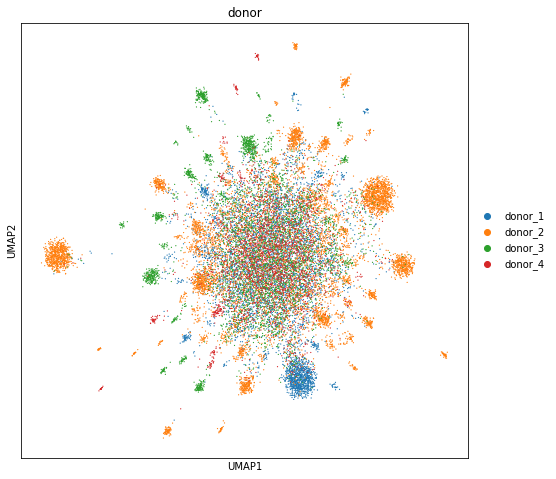

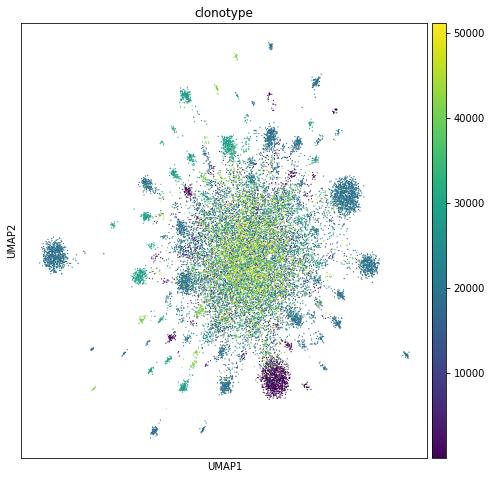

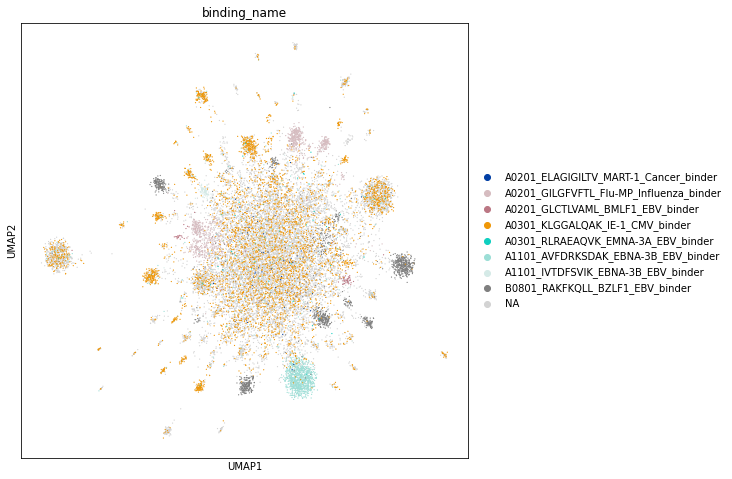

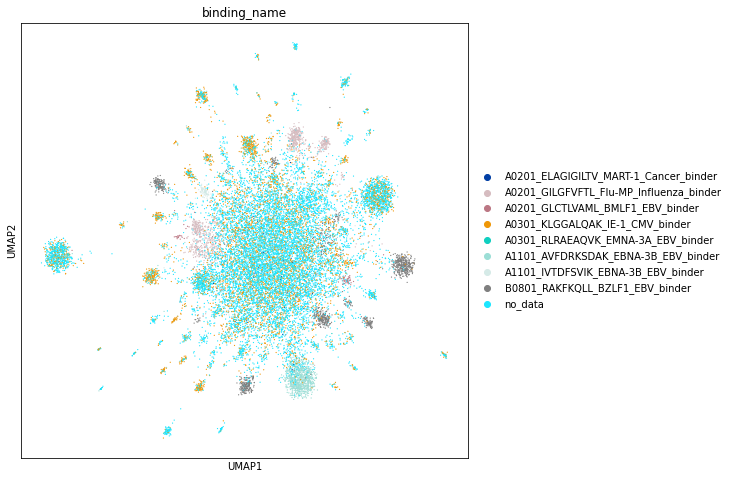

In [11]:
latent_val = annotated_latent_space(data_val)
plot_umap(latent_val)

Create Datasets


C:\Users\felix.drost\Anaconda3\envs\scanpy\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
  1%|▋                                                                                 | 3/343 [00:00<00:14, 22.69it/s]

Latent Embedding


100%|████████████████████████████████████████████████████████████████████████████████| 343/343 [00:08<00:00, 39.75it/s]
... storing 'dataset' as categorical


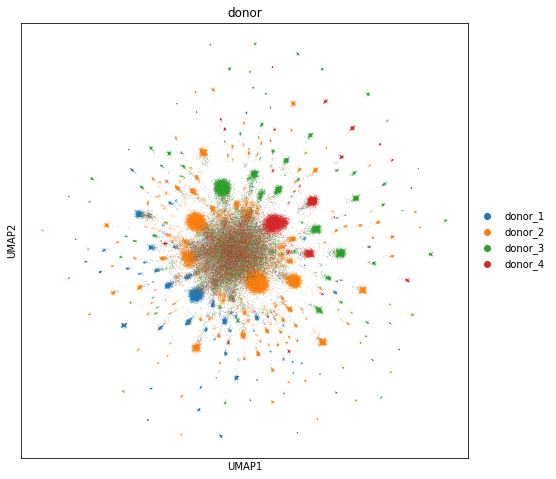

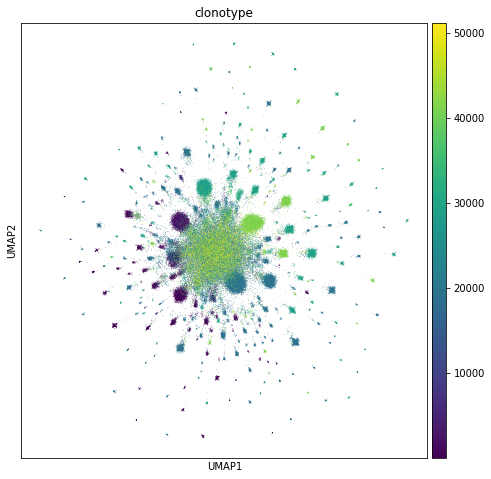

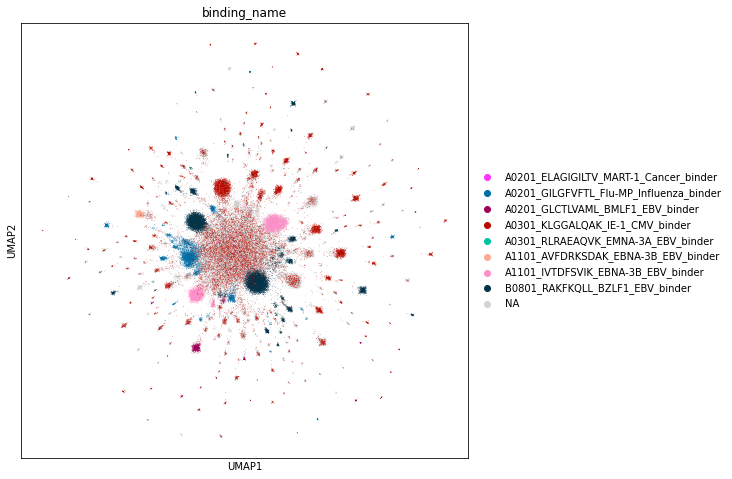

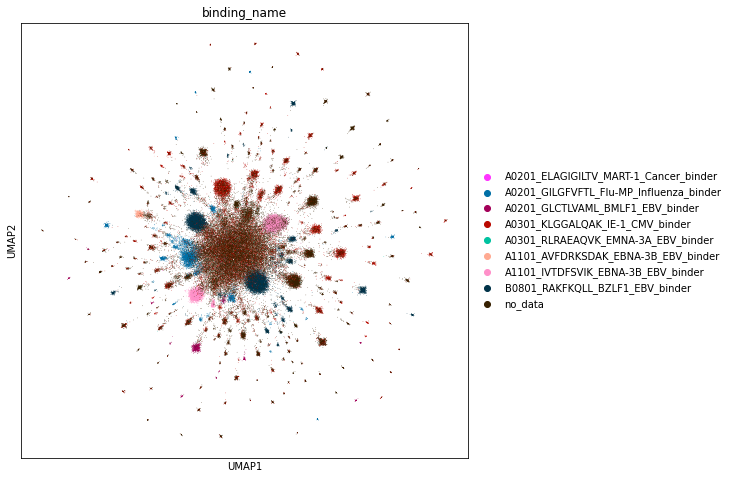

In [13]:
latent_train = annotated_latent_space(data_train)
plot_umap(latent_train)

In [ ]:
latent_full = annotated_latent_space(data_full)
plot_umap(latent_full)